In [52]:
# SN TNS name
tnsname = '2021foa'

# SN discovery date
discovery_date = 59268.45000 - 20.0

# path to directory that contains SN and control light curves
source_dir = '/Users/svoncoelln/Documents/23/2021foa_sophie'

# number of control light curves to load
n_controls = 8

# filter of light curve to analyze
filt = 'o'

# MJD bin size in days of light curve to analyze
mjd_bin_size = 1.0

# define flags that define bad measurements (to filter out bad days in lc)
flags = 0x800000

In [53]:
import pandas as pd
import numpy as np
import sys,copy,random
from pdastro import pdastroclass, pdastrostatsclass, AandB, AnotB, AorB
from asym_gaussian import gauss2lc

# plotting
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import pylab as matlib
import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")

# for storing lc and control lcs 
global lcs
lcs = {}

# for storing info about the lc
global lc_info
lc_info = {}

def load_lc(source_dir, tnsname):
	lcs[0] = pdastrostatsclass()
	filename = f'{source_dir}/{lc_info["tnsname"]}.{lc_info["filt"]}.{lc_info["mjd_bin_size"]:0.2f}days.lc.txt'
	print(f'Loading light curve for SN {tnsname} at {filename}...')
	try:
		lcs[0].load_spacesep(filename,delim_whitespace=True)
	except Exception as e:
		print('ERROR: Could not load light curve at %s: %s' % (filename, str(e)))
		sys.exit()
	
	lc_info['baseline_ix'] = lcs[0].ix_inrange(colnames=['MJDbin'], uplim=lc_info['discovery_date']-20, exclude_uplim=True)
	if len(lc_info['baseline_ix'])<=0:
		print('Baseline length is 0! Exiting...')
		sys.exit()
	lc_info['afterdiscdate_ix'] = AnotB(lcs[0].getindices(), lc_info['baseline_ix']) 

def load_control_lcs(source_dir, tnsname, n_controls): 
	print(f'Loading control light curves for SN {tnsname}...')
	for control_index in range(1, n_controls+1):
		lcs[control_index] = pdastrostatsclass()
		filename = f'{source_dir}/controls/{lc_info["tnsname"]}_i{control_index:03d}.{lc_info["filt"]}.{lc_info["mjd_bin_size"]:0.2f}days.lc.txt'
		print(f'# Loading control light curve {control_index:03d} at {filename}...')
		try:
			lcs[control_index].load_spacesep(filename,delim_whitespace=True)
		except Exception as e:
			print(f'ERROR: Could not load contol light curve {control_index:03d} at {filename}: {str(e)}')
			sys.exit()

def load_lcs(source_dir, tnsname, n_controls):
    load_lc(source_dir, tnsname)
    load_control_lcs(source_dir, tnsname, n_controls)

def load_detected(source_dir, gauss_sigmas, peaks, detected=None):
    detected = {}
    for gauss_sigma in gauss_sigmas:
        for peak in peaks:
            filename = f'{source_dir}/bump_analysis/tables2/detected_{gauss_sigma}_{peak:0.2f}.txt'
            detected[f'{gauss_sigma}_{peak:0.2f}'] = pdastrostatsclass()
            detected[f'{gauss_sigma}_{peak:0.2f}'].load_spacesep(filename=filename, delim_whitespace=True)
    return detected

def load_detected_per_peak(source_dir, detected_per_peak=None):
    filename = f'{source_dir}/bump_analysis/tables2/detected_per_peak.txt'
    detected_per_peak = pdastrostatsclass()
    detected_per_peak.load_spacesep(filename=filename, delim_whitespace=True)
    return detected_per_peak

def apply_gaussian(lc, gaussian_sigma, sim_gauss=False, sim_peakmjd=None, sim_appmag=None, sim_sigma=None, print_=True, flag=0x800000):
    if len(lc_info['baseline_ix']) <= 0:
        print('ERROR: Not enough data in baseline flux (before SN start)!')

    ix = lc_info['baseline_ix'] # all pre-SN indices
    good_ix = AandB(ix, lc.ix_unmasked('Mask', flag)) # all good pre-SN indices

    # make sure there are no lingering simulations
    dropcols=[]
    for col in ['uJysim','SNRsim','simLC','SNRsimsum']:
        if col in lc.t.columns:
            dropcols.append(col)
    if len(dropcols) > 0:
        lc.t.drop(columns=dropcols,inplace=True)

    lc.t.loc[ix, 'SNR'] = 0.0
    lc.t.loc[good_ix,'SNR'] = lc.t.loc[good_ix,'uJy']/lc.t.loc[good_ix,'duJy']

    # add simulated gaussian
    if sim_gauss:
        if print_:
            print(f'# Adding simulated gaussian: peak at MJD {sim_peakmjd:0.2f}; apparent magnitude {sim_appmag:0.2f}; sigma- and sigma+ of {sim_sigma:0.2f} days')
        mjds = lc.t.loc[good_ix,'MJD']
        lc.t.loc[good_ix,'uJysim'] = lc.t.loc[good_ix,'uJy']
        lc.t.loc[ix,'simLC'] = 0.0

        # get simulated gaussian flux and add to light curve flux
        simflux = gauss2lc(mjds, sim_peakmjd, sim_sigma, sim_sigma, app_mag=sim_appmag)
        lc.t.loc[good_ix,'uJysim'] += simflux
        # get the simulated lc for all MJDs
        simflux_all = gauss2lc(lc.t.loc[ix,'MJDbin'], sim_peakmjd, sim_sigma, sim_sigma, app_mag=sim_appmag)
        lc.t.loc[ix,'simLC'] += simflux_all

        # make sure all bad rows have SNRsim = 0.0 so they have no impact on the rolling SNRsum
        lc.t.loc[ix,'SNRsim'] = 0.0
        # include simflux in the SNR
        lc.t.loc[good_ix,'SNRsim'] = lc.t.loc[good_ix,'uJysim']/lc.t.loc[good_ix,'duJy']

    new_gaussian_sigma = round(gaussian_sigma/lc_info['mjd_bin_size'])
    windowsize = int(6 * new_gaussian_sigma)
    halfwindowsize = int(windowsize * 0.5) + 1
    if print_:
        print(f'# Sigma: {gaussian_sigma:0.2f} days; MJD bin size: {lc_info["mjd_bin_size"]:0.2f} days; sigma: {new_gaussian_sigma:0.2f} bins; window size: {windowsize} bins')

    # calculate the rolling SNR sum
    dataindices = np.array(range(len(lc.t.loc[ix])) + np.full(len(lc.t.loc[ix]), halfwindowsize))
    temp = pd.Series(np.zeros(len(lc.t.loc[ix]) + 2*halfwindowsize), name='SNR', dtype=np.float64)
    temp[dataindices] = lc.t.loc[ix,'SNR']
    SNRsum = temp.rolling(windowsize, center=True, win_type='gaussian').sum(std=new_gaussian_sigma)
    lc.t.loc[ix,'SNRsum'] = list(SNRsum[dataindices])
    # normalize it
    norm_temp = pd.Series(np.zeros(len(lc.t.loc[ix]) + 2*halfwindowsize), name='norm', dtype=np.float64)
    norm_temp[np.array(range(len(lc.t.loc[ix])) + np.full(len(lc.t.loc[ix]), halfwindowsize))] = np.ones(len(lc.t.loc[ix]))
    norm_temp_sum = norm_temp.rolling(windowsize, center=True, win_type='gaussian').sum(std=new_gaussian_sigma)
    lc.t.loc[ix,'SNRsumnorm'] = list(SNRsum.loc[dataindices] / norm_temp_sum.loc[dataindices] * max(norm_temp_sum.loc[dataindices]))

    # calculate the rolling SNR sum for SNR with simflux
    if sim_gauss:
        temp = pd.Series(np.zeros(len(lc.t.loc[ix]) + 2*halfwindowsize), name='SNRsim', dtype=np.float64)
        temp[dataindices] = lc.t.loc[ix,'SNRsim']
        SNRsimsum = temp.rolling(windowsize, center=True, win_type='gaussian').sum(std=new_gaussian_sigma)
        lc.t.loc[ix,'SNRsimsum'] = list(SNRsimsum.loc[dataindices])

    return lc

In [54]:
# fill lc_info, load SN lc, and load control lcs
lc_info['tnsname'] = tnsname
lc_info['discovery_date'] = discovery_date
lc_info['filt'] = filt
lc_info['mjd_bin_size'] = mjd_bin_size
load_lcs(source_dir, tnsname, n_controls)

Loading light curve for SN 2021foa at /Users/svoncoelln/Documents/23/2021foa_sophie/2021foa.o.1.00days.lc.txt...
Loading control light curves for SN 2021foa...
# Loading control light curve 001 at /Users/svoncoelln/Documents/23/2021foa_sophie/controls/2021foa_i001.o.1.00days.lc.txt...
# Loading control light curve 002 at /Users/svoncoelln/Documents/23/2021foa_sophie/controls/2021foa_i002.o.1.00days.lc.txt...
# Loading control light curve 003 at /Users/svoncoelln/Documents/23/2021foa_sophie/controls/2021foa_i003.o.1.00days.lc.txt...
# Loading control light curve 004 at /Users/svoncoelln/Documents/23/2021foa_sophie/controls/2021foa_i004.o.1.00days.lc.txt...
# Loading control light curve 005 at /Users/svoncoelln/Documents/23/2021foa_sophie/controls/2021foa_i005.o.1.00days.lc.txt...
# Loading control light curve 006 at /Users/svoncoelln/Documents/23/2021foa_sophie/controls/2021foa_i006.o.1.00days.lc.txt...
# Loading control light curve 007 at /Users/svoncoelln/Documents/23/2021foa_sophie/c

# Plotting SN and control light curves

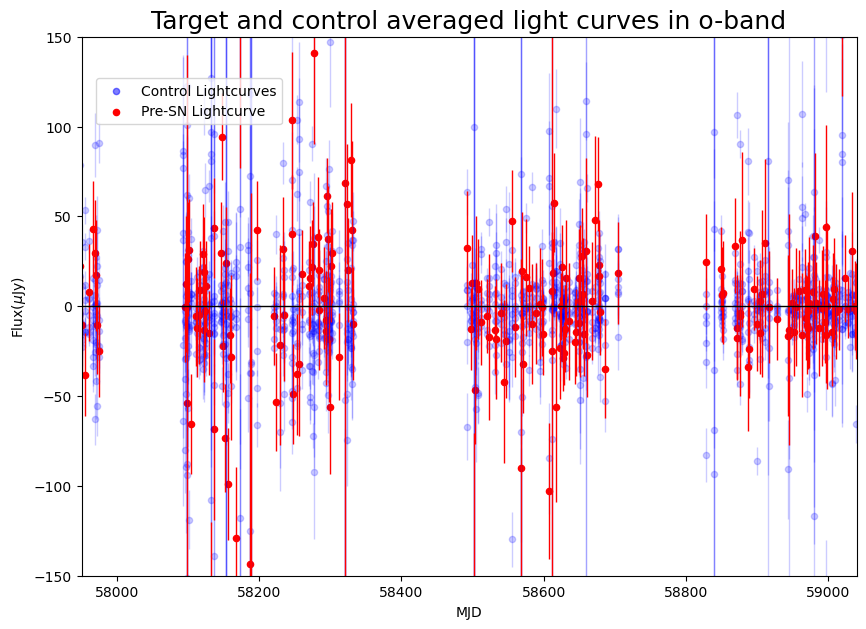

In [55]:
def get_good_ix(control_index):
    return lcs[control_index].ix_unmasked('Mask',maskval=flags)

color = 'red'
ctr_color = 'blue'
test_color = 'green'

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(7)
plt.title(f'Target and control averaged light curves in {filt}-band', fontsize = 18)
plt.ylabel(r'Flux($\mu$Jy)')
plt.xlabel('MJD')

for control_index in range(1, n_controls):
    plt.errorbar(lcs[control_index].t.loc[get_good_ix(control_index),'MJD'], lcs[control_index].t.loc[get_good_ix(control_index),'uJy'], yerr=lcs[control_index].t.loc[get_good_ix(control_index),'duJy'], fmt='none', ecolor=ctr_color, elinewidth=1, c=ctr_color, alpha=0.2)
    plt.scatter(lcs[control_index].t.loc[get_good_ix(control_index),'MJD'], lcs[control_index].t.loc[get_good_ix(control_index),'uJy'], s=20, color=ctr_color, marker='o', alpha=0.2)
plt.scatter(0, 0, s=20, color=ctr_color, marker='o', alpha =0.5, label=r'Control Lightcurves')
plt.errorbar(lcs[0].t.loc[get_good_ix(control_index),'MJD'], lcs[0].t.loc[get_good_ix(control_index),'uJy'], yerr=lcs[0].t.loc[get_good_ix(control_index),'duJy'], fmt='none', ecolor=color, elinewidth=1, c=color)
plt.scatter(lcs[0].t.loc[get_good_ix(control_index),'MJD'], lcs[0].t.loc[get_good_ix(control_index),'uJy'], s=20, color=color, marker='o', label=r'Pre-SN Lightcurve')

plt.axhline(linewidth=1,color='k')
plt.ylim(-150,150)
plt.xlim(57950,59040)
plt.legend(loc='center left', bbox_to_anchor=(0.01, 0.88))

# Applying weighted Gaussian rolling sum to SN and control light curves

In [66]:
# select the gaussian sigma of the rolling gaussian weighted sum to be applied to all light curves
gauss_sigma = 10

Applying gaussian weighted rolling sum to pre-SN light curve 000...
Applying gaussian weighted rolling sum to control light curve 001...
Applying gaussian weighted rolling sum to control light curve 002...
Applying gaussian weighted rolling sum to control light curve 003...
Applying gaussian weighted rolling sum to control light curve 004...
Applying gaussian weighted rolling sum to control light curve 005...
Applying gaussian weighted rolling sum to control light curve 006...
Applying gaussian weighted rolling sum to control light curve 007...
Applying gaussian weighted rolling sum to control light curve 008...


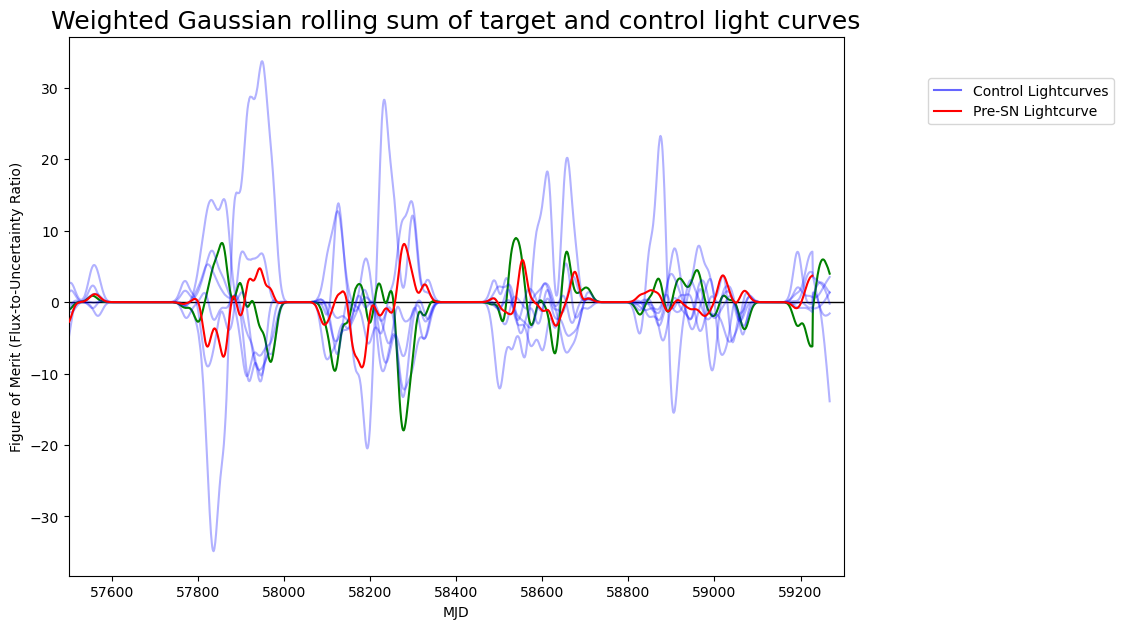

In [67]:
# apply rolling gaussian weighted sum to pre-SN and control light curves
for control_index in range(0, n_controls+1):
    if control_index > 0:
        print(f'Applying gaussian weighted rolling sum to control light curve {control_index:03d}...')
    else:
        print(f'Applying gaussian weighted rolling sum to pre-SN light curve {control_index:03d}...')
    lcs[control_index] = apply_gaussian(lcs[control_index], gauss_sigma, print_=False)

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(7)
plt.title(f'Weighted Gaussian rolling sum of target and control light curves', fontsize = 18)
plt.ylabel('Figure of Merit (Flux-to-Uncertainty Ratio)')
plt.xlabel('MJD')

plt.axhline(linewidth=1,color='k')
for control_index in range(1, n_controls):
    if (control_index is 4):
        plt.plot(lcs[control_index].t['MJDbin'], lcs[control_index].t['SNRsumnorm'], color=test_color)
    else:
        plt.plot(lcs[control_index].t['MJDbin'], lcs[control_index].t['SNRsumnorm'], color=ctr_color, alpha=0.3)
plt.plot([0,1],[0,0], color=ctr_color, alpha=0.6, zorder=0, label=r'Control Lightcurves')
plt.plot(lcs[0].t['MJDbin'], lcs[0].t['SNRsumnorm'], color=color, label='Pre-SN Lightcurve', zorder=20)

plt.xlim(57500,59300)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.88))

# Adding simulated gaussians to a control light curve

In [70]:
# select the gaussian sigma of the rolling gaussian weighted sum to be applied to all light curves
#gauss_sigma = 10 # options: 5, 10, 15

# select the control light curve to add simulated gaussians to
select_index = 4

# parameters of simulated gaussians to be added to selected control light curve

# number of simulated gaussians to add to the light curve
n_sim_gauss = 3

# gaussian sigma for each simulated gaussian
sim_gauss_sigmas = [10, 10, 10]

# peak mjd for each simulated gaussian
sim_peak_mjds = [57900, 58250, 58600]

# width in days for each simulated gaussian
sim_widths = [30, 30, 30] 

# peak flux for each simulated gaussian
sim_peaks = [30, 30, 30] 

Applying gaussian weighted rolling sum to pre-SN light curve 000...
Applying gaussian weighted rolling sum to control light curve 001...
Applying gaussian weighted rolling sum to control light curve 002...
Applying gaussian weighted rolling sum to control light curve 003...
Applying gaussian weighted rolling sum to control light curve 004...
Applying gaussian weighted rolling sum to control light curve 005...
Applying gaussian weighted rolling sum to control light curve 006...
Applying gaussian weighted rolling sum to control light curve 007...
Applying gaussian weighted rolling sum to control light curve 008...
# Adding simulated gaussian: peak at MJD 57900.00; apparent magnitude 20.21; sigma- and sigma+ of 15.00 days
# Sigma: 10.00 days; MJD bin size: 1.00 days; sigma: 10.00 bins; window size: 60 bins
# Adding simulated gaussian: peak at MJD 58250.00; apparent magnitude 20.21; sigma- and sigma+ of 15.00 days
# Sigma: 10.00 days; MJD bin size: 1.00 days; sigma: 10.00 bins; window size

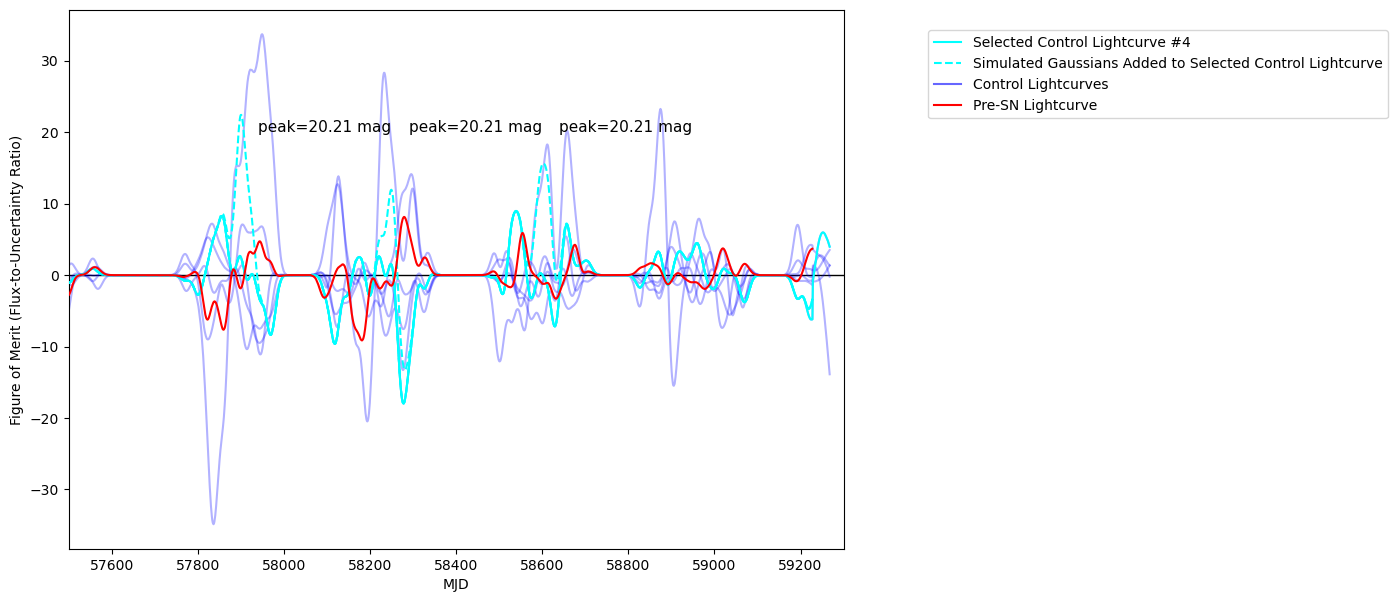

In [71]:
color = 'red'
pick_color = 'cyan'
ctr_color = 'blue'

# apply rolling gaussian weighted sum to pre-SN and control light curves
for control_index in range(0, n_controls+1):
    if control_index > 0:
        print(f'Applying gaussian weighted rolling sum to control light curve {control_index:03d}...')
    else:
        print(f'Applying gaussian weighted rolling sum to pre-SN light curve {control_index:03d}...')
    lcs[control_index] = apply_gaussian(lcs[control_index], gauss_sigma, print_=False)

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(7)
plt.ylabel('Figure of Merit (Flux-to-Uncertainty Ratio)')
plt.xlabel('MJD')
plt.title('')

# add simulated gausssians to selected control light curve
for i in range(n_sim_gauss): # for each simulated gaussian
    # add that simulated gaussian and apply gaussian weighted rolling sum
    simlc = copy.deepcopy(lcs[select_index])
    sim_appmag = -2.5 * np.log10(sim_peaks[i]) + 23.9
    simlc = apply_gaussian(simlc, sim_gauss_sigmas[i], sim_gauss=True, sim_peakmjd=sim_peak_mjds[i], sim_appmag=sim_appmag, sim_sigma=sim_widths[i]/2)
    
    # plot it
    plt.plot(simlc.t['MJDbin'], simlc.t['SNRsimsum'], linestyle='dashed', color=pick_color, zorder=10)
    sim_appmag = -2.5 * np.log10(sim_peaks[i]) + 23.9
    plt.text(sim_peak_mjds[i]+40, 20, f'peak={sim_appmag:0.2f} mag', fontsize=11) #y=sim_peaks[i]

plt.axhline(linewidth=1,color='k')

plt.plot(lcs[select_index].t['MJDbin'], lcs[select_index].t['SNRsumnorm'], color=pick_color, alpha=1, zorder=10, label=f'Selected Control Lightcurve #{select_index}')
for control_index in range(2, n_controls):
        plt.plot(lcs[control_index].t['MJDbin'], lcs[control_index].t['SNRsumnorm'], color=ctr_color, alpha=0.3)
plt.plot([0,1],[0,0], color=pick_color, alpha=1, linestyle='dashed', zorder=0, label=r'Simulated Gaussians Added to Selected Control Lightcurve')
plt.plot([0,1],[0,0], color=ctr_color, alpha=0.6, zorder=0, label=r'Control Lightcurves')
plt.plot(lcs[0].t['MJDbin'], lcs[0].t['SNRsumnorm'], color=color, label='Pre-SN Lightcurve', zorder=20)

plt.xlim(57500,59300)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.88))